In [126]:
import numpy as np
import pandas as pd
from keras_preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten, Dense

from sklearn.preprocessing import StandardScaler
from keras.regularizers import l2
from keras import backend as K

import os
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [127]:
df = pd.read_csv('NN_df.csv')

df.info()

def drop_columns(data, columns_to_drop):
  
    return data.drop(columns=columns_to_drop)

columns_to_drop=['Unnamed: 0.1','Unnamed: 0','id','title','release_date','overview','genres','release_year','filtered_overviews','adult']
df=drop_columns(df, columns_to_drop)

#you mention you choose these variables cus they might have a non linear relationship with revenue. 
#But you are unsure and just keep whacking 
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10824 entries, 0 to 10823
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0.1          10824 non-null  int64  
 1   Unnamed: 0            10824 non-null  int64  
 2   id                    10824 non-null  int64  
 3   title                 10824 non-null  object 
 4   vote_average          10824 non-null  float64
 5   vote_count            10824 non-null  int64  
 6   release_date          10824 non-null  object 
 7   revenue               10824 non-null  int64  
 8   runtime               10824 non-null  int64  
 9   adult                 10824 non-null  bool   
 10  budget                10824 non-null  int64  
 11  original_language     10824 non-null  object 
 12  overview              10824 non-null  object 
 13  popularity            10824 non-null  float64
 14  poster_path           10824 non-null  object 
 15  genres             

,vote_average,vote_count,revenue,runtime,budget,original_language,popularity,poster_path,num_chars,avg_tfidf_score,...,genre_Comedy,genre_Fantasy,genre_Horror,genre_Animation,genre_Music,genre_Family,genre_Thriller,genre_Drama,genre_Mystery,genre_Western
0,8.364,34495,825532764,148,160000000,en,83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,9,0.051960,...,0,0,0,0,0,0,0,0,0,0
1,8.417,32571,701729206,169,165000000,en,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,12,0.070708,...,0,0,0,0,0,0,0,1,0,0
2,8.512,30619,1004558444,152,185000000,en,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,15,0.046420,...,0,0,0,0,0,0,1,1,0,0
3,7.573,29815,2923706026,162,237000000,en,79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,6,0.052632,...,0,1,0,0,0,0,0,0,0,0
4,7.710,29166,1518815515,143,220000000,en,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,12,0.066541,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10819,0.000,0,1,5,1,en,0.600,/ieJdaQ9HP8ogeRjKkalmdByOOH9.jpg,23,0.045455,...,1,0,0,0,0,1,0,1,0,0
10820,0.000,0,100000,53,55000,tr,0.643,/qDCx50gLuPAyLCAT8wxpqVqQbgf.jpg,16,0.041667,...,0,0,0,0,0,0,0,0,0,1
10821,0.000,0,69,2,5,en,0.600,/e8YpXjfAkmNp4nGFEUJwDmp3PnY.jpg,4,0.350134,...,0,0,0,0,0,0,0,0,0,0
10822,0.000,0,120,5,5000,en,0.600,/9aD5jk75SEL9lMsAMpV0dZgRhuC.jpg,16,0.070667,...,0,1,1,0,0,0,0,0,0,0


In [128]:
column_name = 'revenue'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]


column_name = 'budget'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]


column_name = 'vote_average'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]

column_name = 'runtime'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]

column_name = 'num_genres'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]



column_name = 'vote_count'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)


IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]


column_name = 'avg_tfidf_score'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)


IQR = Q3 - Q1

outlier_range = (df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))

df = df.loc[~outlier_range, :]


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6211 entries, 1899 to 10101
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vote_average          6211 non-null   float64
 1   vote_count            6211 non-null   int64  
 2   revenue               6211 non-null   int64  
 3   runtime               6211 non-null   int64  
 4   budget                6211 non-null   int64  
 5   original_language     6211 non-null   object 
 6   popularity            6211 non-null   float64
 7   poster_path           6211 non-null   object 
 8   num_chars             6211 non-null   int64  
 9   avg_tfidf_score       6211 non-null   float64
 10  num_genres            6211 non-null   int64  
 11  genre_Romance         6211 non-null   int64  
 12  genre_Adventure       6211 non-null   int64  
 13  genre_War             6211 non-null   int64  
 14  genre_Action          6211 non-null   int64  
 15  genre_ScienceFiction  

problem 1

In [129]:
numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres','vote_count']
X = df[numerical_features].values
y = df['revenue'].values

In [130]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_model(num_numerical_features):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model

The model architecture is designed with two hidden layers to capture nonlinear relationships in the data. ReLU activation functions are used to introduce nonlinearity, and L2 regularization is applied to prevent overfitting.

Mean squared error is selected as the loss function since the problem is framed as a regression task. R-squared and mean absolute error are chosen as additional evaluation metrics to assess the model's performance.

#basic code 

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = build_model(num_numerical_features=X_train.shape[1])

In [132]:
history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
125/125 [==============================] - 2s 9ms/step - loss: 584627928432640.0000 - r_squared: -0.0770 - mean_absolute_error: 13809450.0000 - val_loss: 395107362668544.0000 - val_r_squared: 0.1295 - val_mean_absolute_error: 12340970.0000
Epoch 2/20
125/125 [==============================] - 1s 5ms/step - loss: 455511480729600.0000 - r_squared: 0.1400 - mean_absolute_error: 12930221.0000 - val_loss: 395245908918272.0000 - val_r_squared: 0.1308 - val_mean_absolute_error: 12325819.0000
Epoch 3/20
125/125 [==============================] - 1s 6ms/step - loss: 455879774175232.0000 - r_squared: 0.0367 - mean_absolute_error: 12943569.0000 - val_loss: 395532329549824.0000 - val_r_squared: 0.1327 - val_mean_absolute_error: 12302641.0000
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 455387329331200.0000 - r_squared: 0.1433 - mean_absolute_error: 12897444.0000 - val_loss: 394845336109056.0000 - val_r_squared: 0.1254 - val_mean_absolute_error: 12384077.0000

In [133]:
test_loss,test_r2, test_mae  = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss:.2f}')
print(f'Test R-squared: {test_r2:.2f}')
print(f'Test Mean Absolute Error: {test_mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')


39/39 [==============================] - 0s 4ms/step - loss: 448985714130944.0000 - r_squared: 0.1398 - mean_absolute_error: 12893710.0000
Test Loss: 448985714130944.00
Test R-squared: 0.14
Test Mean Absolute Error: 12893710.00
Training Loss: 455514165084160.00
Training Mean Absolute Error: 12955134.00
Training R-squared: 0.14


#Basic model 2

In [134]:
def train_test_model_comparison(history, X_train, y_train, X_test, y_test, model):
    plt.figure(figsize=(12, 8))
    
    # Plot training and testing loss (MSE)
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.title('Loss Function')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    
    # Plot training and testing MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Testing MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#graphical representation code

problem 2

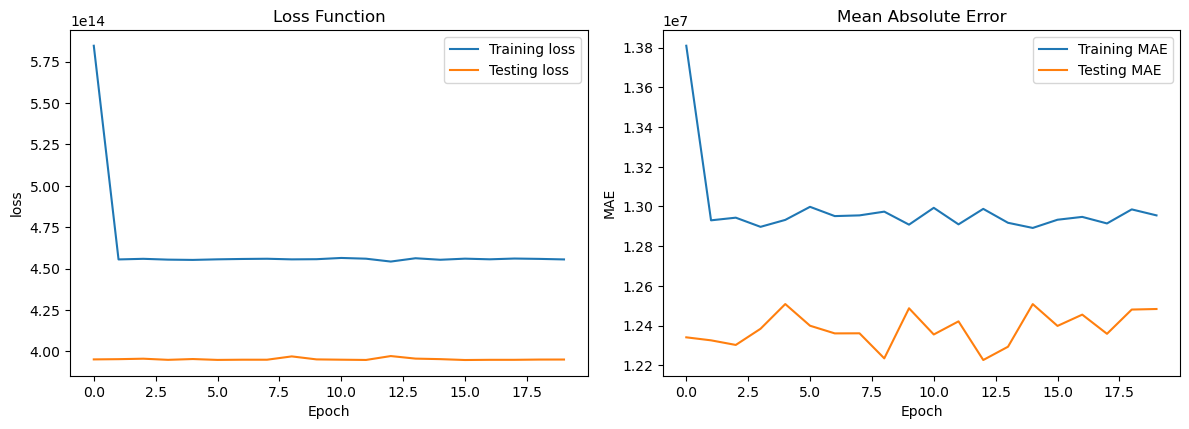

In [135]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

Overfitting as test loss is fluctuating but training loss is decreasing. Same for MAE

In [136]:
numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
X = df[numerical_features].values

y = df['revenue'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Instantiate model
model = build_model(num_numerical_features=X_train.shape[1])

# Train model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')



Epoch 1/60
156/156 [==============================] - 2s 8ms/step - loss: 0.8495 - r_squared: 0.1011 - mean_absolute_error: 0.5981 - val_loss: 0.8086 - val_r_squared: 0.2235 - val_mean_absolute_error: 0.5578
Epoch 2/60
156/156 [==============================] - 1s 5ms/step - loss: 0.7810 - r_squared: 0.2269 - mean_absolute_error: 0.5657 - val_loss: 0.7837 - val_r_squared: 0.2365 - val_mean_absolute_error: 0.5618
Epoch 3/60
156/156 [==============================] - 1s 5ms/step - loss: 0.7697 - r_squared: 0.2115 - mean_absolute_error: 0.5640 - val_loss: 0.7936 - val_r_squared: 0.2394 - val_mean_absolute_error: 0.5411
Epoch 4/60
156/156 [==============================] - 1s 5ms/step - loss: 0.7649 - r_squared: 0.2295 - mean_absolute_error: 0.5617 - val_loss: 0.7827 - val_r_squared: 0.2406 - val_mean_absolute_error: 0.5643
Epoch 5/60
156/156 [==============================] - 1s 6ms/step - loss: 0.7625 - r_squared: 0.2342 - mean_absolute_error: 0.5619 - val_loss: 0.7720 - val_r_squared: 0

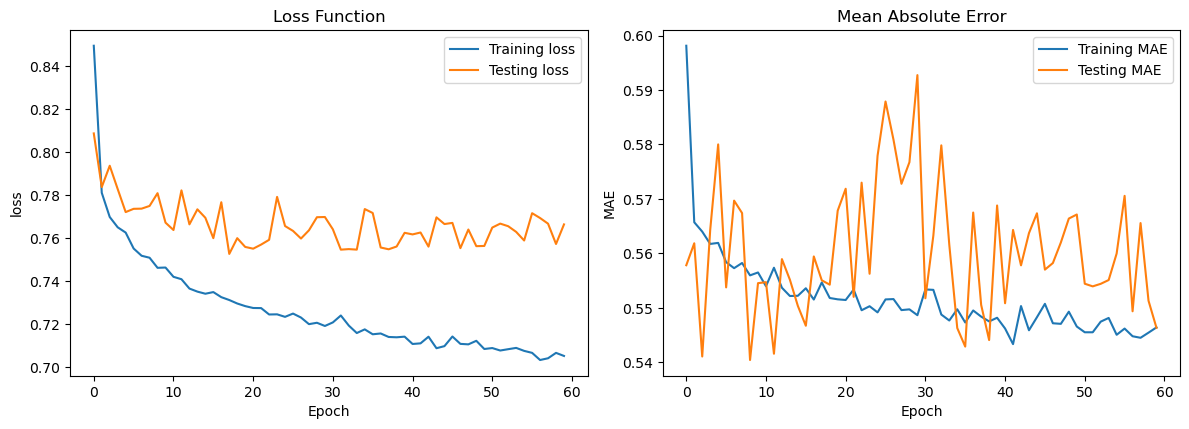

In [137]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

Overfitting as test loss is fluctuating but training loss is decreasing. Same for MAE. Used standard scaling so that the features will be within the same range so that the NN will be less biased to certain variables.

In [138]:
from keras.optimizers import SGD

def build_model1(num_numerical_features):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=SGD(), loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model


In [139]:
numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Instantiate model
model = build_model1(num_numerical_features=X_train.shape[1])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')

Epoch 1/20
156/156 [==============================] - 2s 7ms/step - loss: 0.8458 - r_squared: 0.1519 - mean_absolute_error: 0.6094 - val_loss: 0.8151 - val_r_squared: 0.2154 - val_mean_absolute_error: 0.5689
Epoch 2/20
156/156 [==============================] - 1s 5ms/step - loss: 0.7942 - r_squared: 0.2203 - mean_absolute_error: 0.5701 - val_loss: 0.8013 - val_r_squared: 0.2265 - val_mean_absolute_error: 0.5703
Epoch 3/20
156/156 [==============================] - 1s 4ms/step - loss: 0.7876 - r_squared: 0.1993 - mean_absolute_error: 0.5681 - val_loss: 0.8023 - val_r_squared: 0.2075 - val_mean_absolute_error: 0.5810
Epoch 4/20
156/156 [==============================] - 1s 5ms/step - loss: 0.7828 - r_squared: 0.2237 - mean_absolute_error: 0.5641 - val_loss: 0.7963 - val_r_squared: 0.2163 - val_mean_absolute_error: 0.5927
Epoch 5/20
156/156 [==============================] - 1s 5ms/step - loss: 0.7800 - r_squared: 0.1843 - mean_absolute_error: 0.5652 - val_loss: 0.7999 - val_r_squared: 0

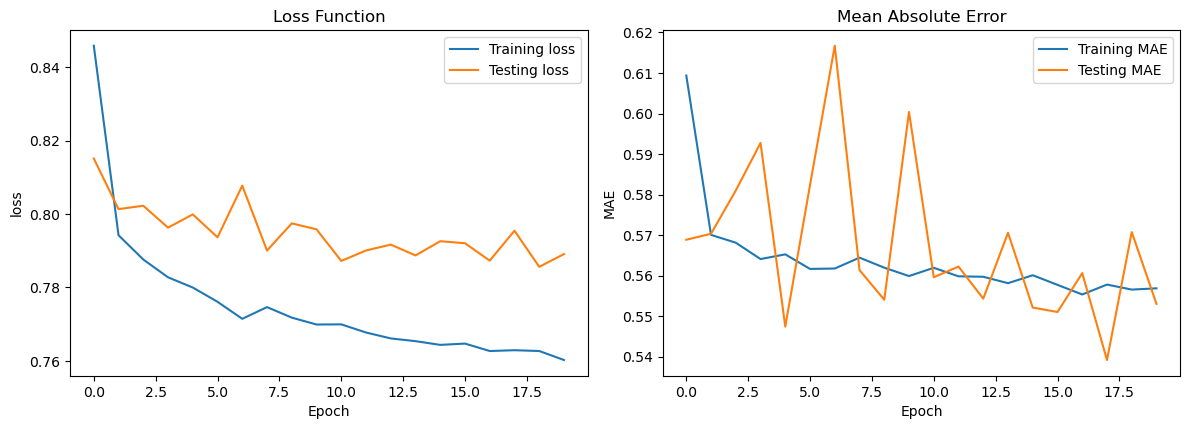

In [140]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

We changed our optimiser from Adam to stochastic gradient descent optimiser as we hypothesized that it would aid the model in learning the test data better and not memorizing it.

As can be seen from the graphs, there is still overfitting to reduce. Also, apart from training R-squared which decreased by 0.16, other metrics remained constant

In [154]:

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_model2(num_numerical_features, learning_rate=0.0001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model


numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
X = df[numerical_features].values


y = df['revenue'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten() 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


model = build_model2(num_numerical_features=X_train.shape[1], learning_rate=0.0001)

history = model.fit(X_train, y_train, epochs=0, batch_size=32, validation_data=(X_test, y_test), verbose=1)

loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')


Epoch 1/20
156/156 [==============================] - 2s 6ms/step - loss: 0.9880 - r_squared: 0.0279 - mean_absolute_error: 0.6584 - val_loss: 0.9234 - val_r_squared: 0.1282 - val_mean_absolute_error: 0.6183
Epoch 2/20
156/156 [==============================] - 1s 5ms/step - loss: 0.8579 - r_squared: 0.1551 - mean_absolute_error: 0.6067 - val_loss: 0.8445 - val_r_squared: 0.1993 - val_mean_absolute_error: 0.5884
Epoch 3/20
156/156 [==============================] - 1s 6ms/step - loss: 0.8132 - r_squared: 0.1845 - mean_absolute_error: 0.5883 - val_loss: 0.8170 - val_r_squared: 0.2176 - val_mean_absolute_error: 0.5769
Epoch 4/20
156/156 [==============================] - 1s 7ms/step - loss: 0.7979 - r_squared: 0.1891 - mean_absolute_error: 0.5797 - val_loss: 0.8071 - val_r_squared: 0.2241 - val_mean_absolute_error: 0.5677
Epoch 5/20
156/156 [==============================] - 1s 7ms/step - loss: 0.7910 - r_squared: 0.2160 - mean_absolute_error: 0.5734 - val_loss: 0.8009 - val_r_squared: 0

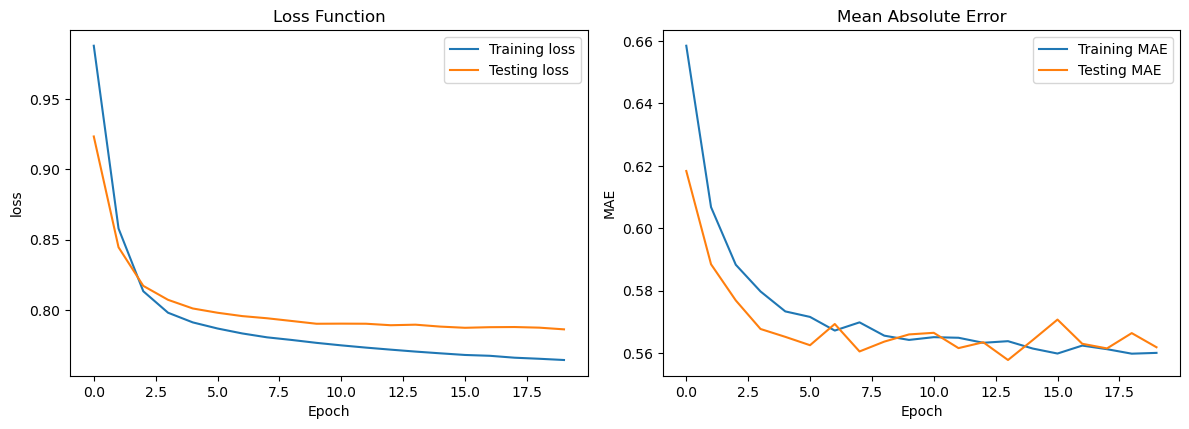

In [155]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

Adjusted learning rate down to 0.0001. A small learning rate can lead to more stable training dynamics. It helps prevent large fluctuations in the loss and parameter updates, which can destabilize training.

After decreasing learning rate, the loss function and MAE become more stable over the epochs, decreasing with as the training loss funciton also decreases, hence reducing overfitting

Need to adjust number of epochs to find ideal train loss fucntion.

In [143]:

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



def build_model2(num_numerical_features, learning_rate=0.0001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model

numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']

X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Example usage with a custom learning rate of 0.01
model = build_model2(num_numerical_features=X_train.shape[1], learning_rate=0.0001)


# Train model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')



Epoch 1/200
156/156 [==============================] - 2s 8ms/step - loss: 1.0690 - r_squared: -0.0364 - mean_absolute_error: 0.6395 - val_loss: 0.9587 - val_r_squared: 0.0960 - val_mean_absolute_error: 0.6112
Epoch 2/200
156/156 [==============================] - 1s 5ms/step - loss: 0.8859 - r_squared: 0.1364 - mean_absolute_error: 0.6056 - val_loss: 0.8555 - val_r_squared: 0.1888 - val_mean_absolute_error: 0.5851
Epoch 3/200
156/156 [==============================] - 2s 10ms/step - loss: 0.8197 - r_squared: 0.1900 - mean_absolute_error: 0.5854 - val_loss: 0.8161 - val_r_squared: 0.2177 - val_mean_absolute_error: 0.5690
Epoch 4/200
156/156 [==============================] - 1s 5ms/step - loss: 0.7967 - r_squared: 0.2142 - mean_absolute_error: 0.5745 - val_loss: 0.8023 - val_r_squared: 0.2231 - val_mean_absolute_error: 0.5679
Epoch 5/200
156/156 [==============================] - 1s 5ms/step - loss: 0.7879 - r_squared: 0.2165 - mean_absolute_error: 0.5713 - val_loss: 0.7971 - val_r_squ

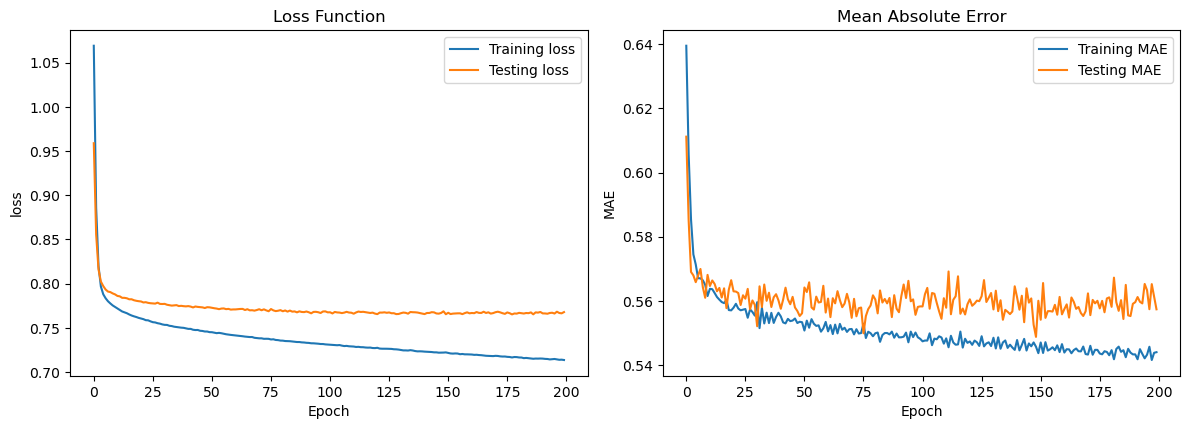

In [144]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

test loss decreased by 0.01 from 30 epochs to 200 epochs. Slight fluctuation of test loss and its plateauing while train loss is decreasing, hence resulting in overfitting. MAE fluctuated more for test and train curves. Training loss decreased by 0.05 as the model as learnt the data better

Use early stop method to reduce any overfitting.

In [145]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_model3(num_numerical_features, learning_rate=0.001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)
    
    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model

numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']

X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the model
model = build_model3(num_numerical_features=X_train.shape[1], learning_rate=0.0001)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping and validation data
history=model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')


Epoch 1/200
156/156 [==============================] - 2s 7ms/step - loss: 0.8330 - r_squared: 0.1592 - mean_absolute_error: 0.5970 - val_loss: 0.7985 - val_r_squared: 0.2260 - val_mean_absolute_error: 0.5621
Epoch 2/200
156/156 [==============================] - 1s 5ms/step - loss: 0.7833 - r_squared: 0.1818 - mean_absolute_error: 0.5698 - val_loss: 0.7921 - val_r_squared: 0.2296 - val_mean_absolute_error: 0.5683
Epoch 3/200
156/156 [==============================] - 1s 6ms/step - loss: 0.7716 - r_squared: 0.2087 - mean_absolute_error: 0.5631 - val_loss: 0.7914 - val_r_squared: 0.2397 - val_mean_absolute_error: 0.5409
Epoch 4/200
156/156 [==============================] - 1s 6ms/step - loss: 0.7665 - r_squared: 0.2489 - mean_absolute_error: 0.5619 - val_loss: 0.7695 - val_r_squared: 0.2417 - val_mean_absolute_error: 0.5588
Epoch 5/200
156/156 [==============================] - 1s 6ms/step - loss: 0.7587 - r_squared: 0.2275 - mean_absolute_error: 0.5593 - val_loss: 0.7686 - val_r_squar

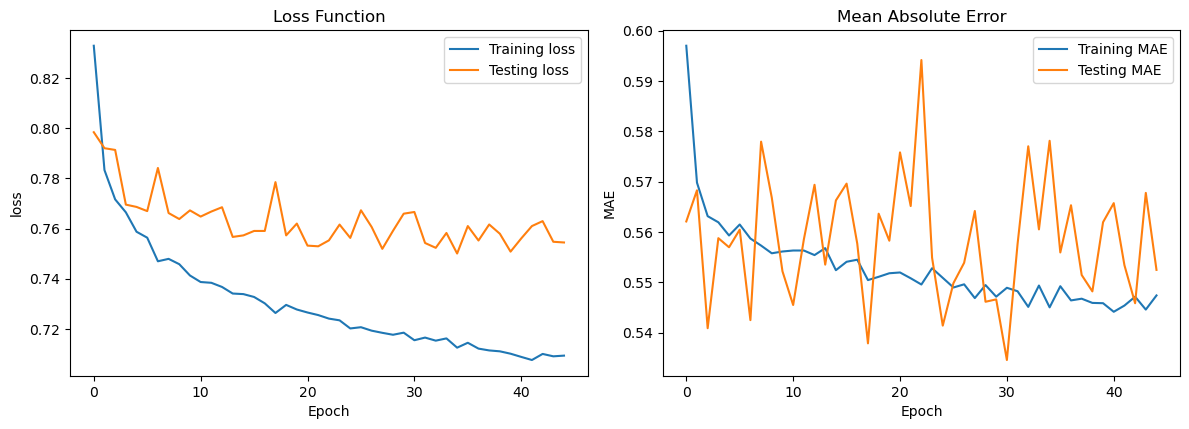

In [146]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)


The early stop method was not effective in reducing overfitting for the model, as can be seen from the fluctuation, overfitting was once again introduced

In [ ]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_model2(num_numerical_features, learning_rate=0.0001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu')(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model


numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
for col in df.columns:
    col = str(col)
    if col.startswith('genre_'):
        numerical_features.append(col)
X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Example usage with a custom learning rate of 0.01
model = build_model2(num_numerical_features=X_train.shape[1], learning_rate=0.0001)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping and validation data
history=model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')


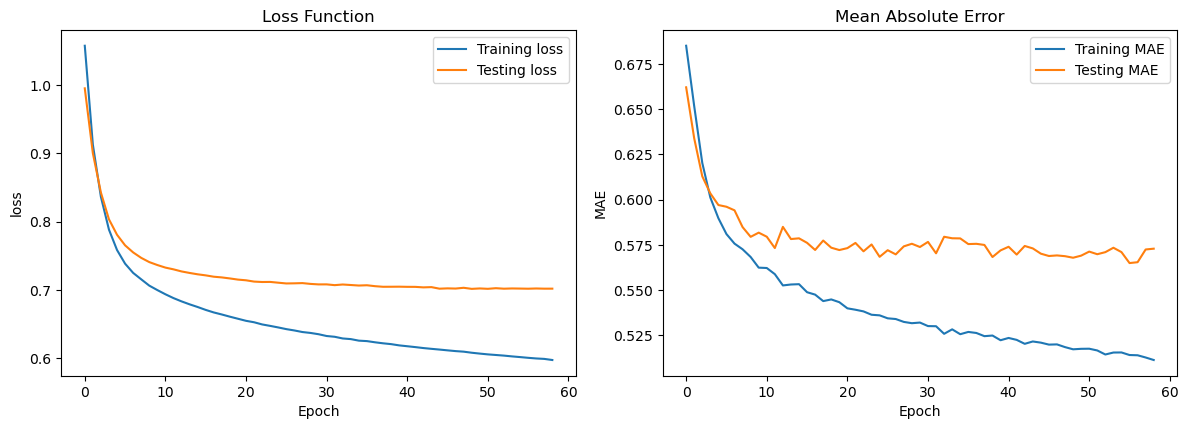

In [148]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

In [149]:
#more columns without early_stop
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



def build_model2(num_numerical_features, learning_rate=0.0001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model

numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
for col in df.columns:
    col = str(col)
    if col.startswith('genre_'):
        numerical_features.append(col)
X = df[numerical_features].values

X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Example usage with a custom learning rate of 0.01
model = build_model2(num_numerical_features=X_train.shape[1], learning_rate=0.0001)


# Train model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')



Epoch 1/200
156/156 [==============================] - 4s 17ms/step - loss: 0.9877 - r_squared: 0.0258 - mean_absolute_error: 0.6695 - val_loss: 0.9886 - val_r_squared: 0.0580 - val_mean_absolute_error: 0.6627
Epoch 2/200
156/156 [==============================] - 2s 13ms/step - loss: 0.9060 - r_squared: 0.1031 - mean_absolute_error: 0.6308 - val_loss: 0.9303 - val_r_squared: 0.1170 - val_mean_absolute_error: 0.6325
Epoch 3/200
156/156 [==============================] - 1s 9ms/step - loss: 0.8608 - r_squared: 0.1615 - mean_absolute_error: 0.6065 - val_loss: 0.8922 - val_r_squared: 0.1489 - val_mean_absolute_error: 0.6218
Epoch 4/200
156/156 [==============================] - 1s 6ms/step - loss: 0.8317 - r_squared: 0.1610 - mean_absolute_error: 0.5953 - val_loss: 0.8657 - val_r_squared: 0.1710 - val_mean_absolute_error: 0.6098
Epoch 5/200
156/156 [==============================] - 1s 6ms/step - loss: 0.8121 - r_squared: 0.1910 - mean_absolute_error: 0.5839 - val_loss: 0.8490 - val_r_squ

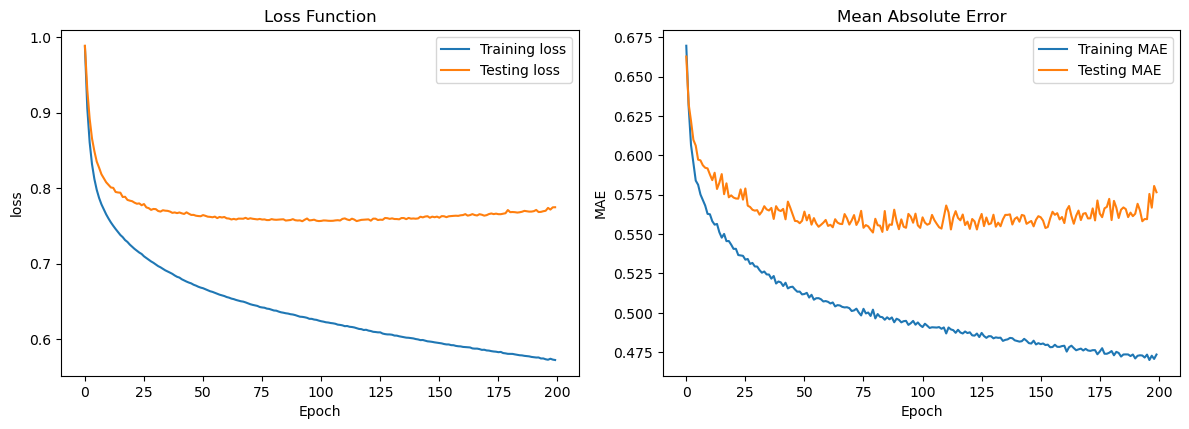

In [150]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

To reduce overfitting and loss, we included more variables inside the dataset. These are variables that could potentially have an effect on revenue. Here we added the one-hot encoded genre columns.

Test and train loss fluctuation decrease, but still train loss continues to decrease while test loss plateaus. The difference between train and test loss has increased to 0.20. Thus early_stop needs to be used again


In [151]:

#more variables with early_stop
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def build_model2(num_numerical_features, learning_rate=0.0001):
    numerical_inputs = Input(shape=(num_numerical_features,), name='numerical_input')
    hidden_layer_1 = Dense(64, activation='relu')(numerical_inputs)
    hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
    output_layer = Dense(1, activation='linear', name='revenue')(hidden_layer_2)

    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=numerical_inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r_squared, 'mean_absolute_error'])

    return model


numerical_features = ['budget', 'runtime', 'vote_average','avg_tfidf_score','num_genres']
for col in df.columns:
    col = str(col)
    if col.startswith('genre_'):
        numerical_features.append(col)
X = df[numerical_features].values

# Target variable
y = df['revenue'].values

# Standardize entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape and flatten y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Example usage with a custom learning rate of 0.01
model = build_model2(num_numerical_features=X_train.shape[1], learning_rate=0.0001)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping and validation data
history=model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
loss, r2, mae= model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test R-squared: {r2:.2f}')
print(f'Test Mean Absolute Error: {mae:.2f}')

train_loss = history.history['loss'][-1]
train_mae = history.history['mean_absolute_error'][-1]
train_r2 = history.history['r_squared'][-1]

print(f'Training Loss: {train_loss:.2f}')
print(f'Training Mean Absolute Error: {train_mae:.2f}')
print(f'Training R-squared: {train_r2:.2f}')


Epoch 1/200
156/156 [==============================] - 2s 8ms/step - loss: 1.1362 - r_squared: -0.2144 - mean_absolute_error: 0.7882 - val_loss: 1.0364 - val_r_squared: -0.0819 - val_mean_absolute_error: 0.7292
Epoch 2/200
156/156 [==============================] - 1s 7ms/step - loss: 0.9599 - r_squared: -0.0525 - mean_absolute_error: 0.7048 - val_loss: 0.9260 - val_r_squared: 0.0449 - val_mean_absolute_error: 0.6695
Epoch 3/200
156/156 [==============================] - 1s 6ms/step - loss: 0.8672 - r_squared: 0.0727 - mean_absolute_error: 0.6538 - val_loss: 0.8601 - val_r_squared: 0.1097 - val_mean_absolute_error: 0.6425
Epoch 4/200
156/156 [==============================] - 1s 6ms/step - loss: 0.8120 - r_squared: 0.1285 - mean_absolute_error: 0.6266 - val_loss: 0.8190 - val_r_squared: 0.1462 - val_mean_absolute_error: 0.6276
Epoch 5/200
156/156 [==============================] - 1s 7ms/step - loss: 0.7769 - r_squared: 0.1750 - mean_absolute_error: 0.6109 - val_loss: 0.7936 - val_r_sq

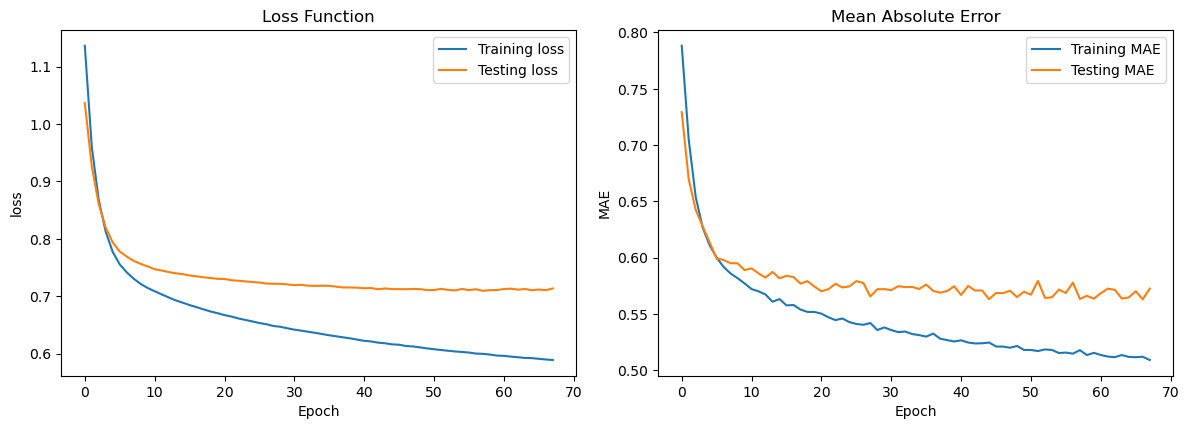

In [152]:
train_test_model_comparison(history, X_train, y_train, X_test, y_test, model)

With early_stop, the difference between the decreases as train_loss is 0.59 and test_loss is 0.71.Thus, overfitting is reduced. R^2 is 0.36 for train, showing that the model better understood the dataset compared to the earlier versions of which some had 0.24.

In [153]:
first_layer_weights = model.layers[1].get_weights()[0]
print('Learned weights for each input variable:')
for i in range(X_train.shape[1]):
    print(f'Variable {i}: {first_layer_weights[:, i]}')
    variable_weights = first_layer_weights[:, i]
    avg_mag = np.mean(np.abs(variable_weights))
    print(f'Variable {i}: Average Magnitude = {avg_mag:.4f}')

Learned weights for each input variable:
Variable 0: [-0.04790913  0.19481593 -0.09756435  0.02380435 -0.22066875 -0.21955088
 -0.26806155  0.26807344  0.174526    0.06411878 -0.19340613 -0.0474197
  0.04292724  0.10487609  0.19080418 -0.15960374  0.02457982 -0.22835167
 -0.22253703  0.05279456  0.16068912 -0.18338387 -0.18057372 -0.1460691 ]
Variable 0: Average Magnitude = 0.1465
Variable 1: [ 0.21247299  0.15673335 -0.01893611  0.04023221 -0.22028747  0.24579747
 -0.22589633 -0.0870387  -0.17447977  0.11466648  0.14371923  0.1500253
 -0.04071072 -0.0331153  -0.04437741  0.04663521  0.20904875 -0.25114948
 -0.10312483 -0.26813293  0.15257205  0.15398772 -0.04296467 -0.19176246]
Variable 1: Average Magnitude = 0.1387
Variable 2: [ 0.00139575  0.1386283  -0.15433323 -0.1922829   0.03208508 -0.1825843
  0.1459729   0.19876017 -0.10808216 -0.14620365  0.00089958 -0.12430187
  0.05498163 -0.14408635  0.05217329  0.22649844  0.07019176  0.23522401
 -0.11912739 -0.00354926 -0.08312004  0.042

The average magnitude of weights can give you an idea of the overall strength or scale of the weights in each layer. Larger average magnitudes generally indicate that the layer has a stronger influence on the subsequent layers and the final output. However, the interpretation of these values should be done in the context of your specific problem and model architecture.

So we calculated the average weight of the variables learned by the NN to draw any insights about the importance of a variable for calculating revenue.